In [1]:
from pathlib import Path
import zipfile, shutil, os

DRIVE_ROOT = Path(r"G:\.shortcut-targets-by-id\1aZ1tJ3YYcWuL3oWKnrTIC5gq46zx1bMc\Rellis-3D_Release")

if not DRIVE_ROOT.exists():
    raise FileNotFoundError(
        f"Drive path not found:\n{DRIVE_ROOT}\n"
        "Open the folder in Explorer and copy the exact path here. "
        "Also mark it 'Available offline' in Google Drive desktop."
    )
LOCAL_CACHE = Path.home() / "data" / "RELLIS_LOCAL"
RGB_DIR   = LOCAL_CACHE / "rgb"
LIDAR_DIR = LOCAL_CACHE / "lidar"
CALIB_DIR = LOCAL_CACHE / "calib"
for d in (RGB_DIR, LIDAR_DIR, CALIB_DIR):
    d.mkdir(parents=True, exist_ok=True)

def unzip_to(zip_path: Path, out_dir: Path):
    out_dir.mkdir(parents=True, exist_ok=True)
    with zipfile.ZipFile(zip_path, 'r') as zf:
        zf.extractall(out_dir)

if (DRIVE_ROOT / "rgb").exists() and (DRIVE_ROOT / "lidar").exists() and (DRIVE_ROOT / "calib").exists():
    # Use Drive folders directly (they should be offline-cached to avoid slowness)
    DATA_ROOT = DRIVE_ROOT
    RGB_DIR   = DATA_ROOT / "rgb"
    LIDAR_DIR = DATA_ROOT / "lidar"
    CALIB_DIR = DATA_ROOT / "calib"

else:
    img_zip   = next((p for p in DRIVE_ROOT.rglob("*image_examples.zip")), None)
    lidar_zip = next((p for p in DRIVE_ROOT.rglob("*lidar_example.zip")), None)
    
    calib_dir = next((p for p in DRIVE_ROOT.rglob("calibration")), None)
    if calib_dir is None:
        calib_dir = next((p for p in DRIVE_ROOT.rglob("calib")), None)

    if img_zip:
        tmp_img = LOCAL_CACHE / "_img"
        unzip_to(img_zip, tmp_img)
        for p in tmp_img.rglob("*.png"):
            shutil.move(str(p), str(RGB_DIR / p.name))
        for p in tmp_img.rglob("*.jpg"):
            shutil.move(str(p), str(RGB_DIR / p.name))

    if lidar_zip:
        tmp_lidar = LOCAL_CACHE / "_lidar"
        unzip_to(lidar_zip, tmp_lidar)
        for ext in (".bin", ".pcd"):
            for p in tmp_lidar.rglob(f"*{ext}"):
                shutil.move(str(p), str(LIDAR_DIR / p.name))

    if calib_dir and calib_dir.is_dir():
        for p in calib_dir.rglob("*"):
            if p.is_file():
                shutil.copy2(str(p), str(CALIB_DIR / p.name))

    
    DATA_ROOT = LOCAL_CACHE

print("DATA_ROOT:", DATA_ROOT)
print("RGB samples:",   len(list(RGB_DIR.glob('*'))))
print("LiDAR samples:", len(list(LIDAR_DIR.glob('*'))))
print("Calib files:",   len(list(CALIB_DIR.glob('*'))))


DATA_ROOT: C:\Users\Miles\data\RELLIS_LOCAL
RGB samples: 8
LiDAR samples: 8
Calib files: 14


In [2]:
DATA_ROOT = Path("/content/rellis_work/RELLIS_LOCAL")

# If you have a custom 'rock' detector in Drive, point here:
MODEL_WEIGHTS = Path("/content/drive/MyDrive/rock_yolov8n.pt")  # change if needed
CONF_THRES, IOU_THRES = 0.25, 0.45
ROCK_CLASS_NAME, ROCK_CLASS_ID = "rock", None

In [3]:
from pathlib import Path

DRIVE_ROOT = Path(r"G:\.shortcut-targets-by-id\1aZ1tJ3YYcWuL3oWKnrTIC5gq46zx1bMc\Rellis-3D_Release")
print("Drive root exists?", DRIVE_ROOT.exists())
print("Top-level entries:", [p.name for p in DRIVE_ROOT.iterdir()])


Drive root exists? True
Top-level entries: ['Rellis_3D_pylon_camera_node.zip', 'Rellis_3D_os1_cloud_node_semantickitti_label_id.zip', 'Rellis_3D_pylon_camera_node_label_id.zip', 'Rellis_3D_pylon_camera_node_label_color.zip', 'Rellis_3D_os1_cloud_node_kitti_bin.zip', 'Rellis_3D_os1_cloud_node_color_ply.zip', 'bags', 'Rellis_3D_image_split.zip', 'Rellis_3D_lidar_split.zip', 'Rellis_3D_image_examples.zip', 'Rellis_3D_lidar_example.zip', 'pretrained_models', 'calibration', 'Rellis_3D_ontology.zip', 'Rellis_3D_os1_cloud_node_semantickitti_label_id_20210614.zip', 'Rellis_3D_vel_cloud_node_kitti_bin.zip', 'Rellis_3D_vel_cloud_node_semantickitti_label_id.zip']


In [4]:
from pathlib import Path
import zipfile, shutil, os

# Local cache (fast SSD if possible)
LOCAL_CACHE = Path.home() / "data" / "RELLIS_LOCAL"
RGB_DIR   = LOCAL_CACHE / "rgb"
LIDAR_DIR = LOCAL_CACHE / "lidar"
CALIB_DIR = LOCAL_CACHE / "calib"
for d in (RGB_DIR, LIDAR_DIR, CALIB_DIR): d.mkdir(parents=True, exist_ok=True)

# Helper: extract only first N matching files from a zip into a target dir
def extract_sample_from_zip(zip_path: Path, patterns=(".png",".jpg",".jpeg"), out_dir: Path = None, N: int = 20):
    out_dir = out_dir or (zip_path.parent / "_sample")
    out_dir.mkdir(parents=True, exist_ok=True)
    picked = 0
    with zipfile.ZipFile(zip_path, 'r') as zf:
        # sort names to keep order stable
        for name in sorted(zf.namelist()):
            low = name.lower()
            if any(low.endswith(ext) for ext in patterns):
                # avoid folder entries
                if name.endswith("/"): 
                    continue
                # ensure parent dir exists
                (out_dir / Path(name).name).parent.mkdir(parents=True, exist_ok=True)
                with zf.open(name) as src, open(out_dir / Path(name).name, "wb") as dst:
                    shutil.copyfileobj(src, dst)
                picked += 1
                if picked >= N:
                    break
    return out_dir, picked

# Try to locate small example zips first; if not found, fall back to the big camera/lidar zips
img_zip = None
lidar_zip = None

# Prefer the example zips if they exist
for p in DRIVE_ROOT.rglob("*image_examples.zip"):
    img_zip = p; break
for p in DRIVE_ROOT.rglob("*lidar_example.zip"):
    lidar_zip = p; break

# Fall back to bigger archives if needed (only sample a few files!)
if img_zip is None:
    for p in DRIVE_ROOT.rglob("*pylon*camera*zip"):
        img_zip = p; break
if lidar_zip is None:
    for p in DRIVE_ROOT.rglob("*os1*cloud*bin*.zip"):
        lidar_zip = p; break

print("Found image zip:", img_zip)
print("Found lidar zip:", lidar_zip)

# Extract small samples
if img_zip:
    sample_img_dir, n_img = extract_sample_from_zip(img_zip, patterns=(".png",".jpg",".jpeg"), out_dir=LOCAL_CACHE/"_img_sample", N=30)
    # move into rgb/
    for p in sorted(sample_img_dir.glob("*")):
        if p.suffix.lower() in (".png",".jpg",".jpeg"):
            shutil.move(str(p), str(RGB_DIR / p.name))

if lidar_zip:
    sample_lidar_dir, n_lidar = extract_sample_from_zip(lidar_zip, patterns=(".bin",".pcd"), out_dir=LOCAL_CACHE/"_lidar_sample", N=30)
    # move into lidar/
    for p in sorted(sample_lidar_dir.glob("*")):
        if p.suffix.lower() in (".bin",".pcd"):
            shutil.move(str(p), str(LIDAR_DIR / p.name))

# Copy calibration if present on Drive
calib_src = next((p for p in DRIVE_ROOT.rglob("calibration") if p.is_dir()), None)
if calib_src:
    for f in calib_src.rglob("*"):
        if f.is_file():
            shutil.copy2(str(f), str(CALIB_DIR / f.name))

print("RGB samples:",   len(list(RGB_DIR.glob('*'))))
print("LiDAR samples:", len(list(LIDAR_DIR.glob('*'))))
print("Calib files:",   len(list(CALIB_DIR.glob('*'))))


Found image zip: G:\.shortcut-targets-by-id\1aZ1tJ3YYcWuL3oWKnrTIC5gq46zx1bMc\Rellis-3D_Release\Rellis_3D_image_examples.zip
Found lidar zip: G:\.shortcut-targets-by-id\1aZ1tJ3YYcWuL3oWKnrTIC5gq46zx1bMc\Rellis-3D_Release\Rellis_3D_lidar_example.zip
RGB samples: 8
LiDAR samples: 8
Calib files: 14


In [5]:
# TEMP calibration only if missing (replace with real YAMLs when available)
import numpy as np, cv2 as cv, yaml

intr_out = CALIB_DIR / "cam_intrinsics.yaml"
extr_out = CALIB_DIR / "extrinsics_cam_lidar.yaml"

if not intr_out.exists() or not extr_out.exists():
    sample_img = next(iter(RGB_DIR.glob("*.png")), None) or next(iter(RGB_DIR.glob("*.jpg")), None)
    if sample_img is None:
        raise FileNotFoundError("Still no images in RGB_DIR; verify extraction above.")

    img = cv.imread(str(sample_img), cv.IMREAD_COLOR)
    H, W = img.shape[:2]

    HFOV_deg = 60.0
    HFOV = np.deg2rad(HFOV_deg)
    fx = (W/2) / np.tan(HFOV/2)
    fy = fx
    cx, cy = W/2, H/2

    K = np.array([[fx, 0,  cx],
                  [0,  fy, cy],
                  [0,  0,   1]], dtype=float)
    D = np.zeros(5, dtype=float)

    with open(intr_out, "w") as f:
        yaml.safe_dump({"image_width": int(W), "image_height": int(H), "K": K.reshape(-1).tolist(), "D": D.tolist()}, f)

    T = np.eye(4, dtype=float)  # placeholder; replace with real extrinsics when you have them
    with open(extr_out, "w") as f:
        yaml.safe_dump({"T_cam_lidar": T.reshape(-1).tolist()}, f)

print("Calibration ready:")
print("  ", intr_out)
print("  ", extr_out)



Calibration ready:
   C:\Users\Miles\data\RELLIS_LOCAL\calib\cam_intrinsics.yaml
   C:\Users\Miles\data\RELLIS_LOCAL\calib\extrinsics_cam_lidar.yaml


In [6]:
from pathlib import Path
import yaml, numpy as np, cv2 as cv, pandas as pd

CALIB_DIR = Path(r"C:\Users\Miles\data\RELLIS_LOCAL\calib")

def load_intrinsics(yaml_path: Path):
    with open(yaml_path, 'r') as f:
        y = yaml.safe_load(f) or {}
    # handle either flat K or nested camera_matrix
    if "K" in y:
        K = np.array(y["K"], dtype=float).reshape(3,3)
    else:
        cm = y.get("camera_matrix")
        K = np.array(cm.get("data", cm), dtype=float).reshape(3,3)
    D = np.array(y.get("D") or y.get("dist_coeffs") or [0,0,0,0,0], dtype=float).ravel()
    return K, D

def load_extrinsics(yaml_path: Path):
    with open(yaml_path, 'r') as f:
        y = yaml.safe_load(f) or {}
    T = y.get("T") or y.get("T_cam_lidar") or y.get("T_lidar_cam")
    return np.array(T, dtype=float).reshape(4,4)

K, D = load_intrinsics(CALIB_DIR / "cam_intrinsics.yaml")
T    = load_extrinsics(CALIB_DIR / "extrinsics_cam_lidar.yaml")

def load_lidar(path: str) -> np.ndarray:
    p = Path(path)
    if p.suffix.lower()==".bin":
        return np.fromfile(p, dtype=np.float32).reshape(-1,4)[:, :3]
    elif p.suffix.lower()==".pcd":
        import open3d as o3d
        pc = o3d.io.read_point_cloud(str(p))
        return np.asarray(pc.points, dtype=np.float32)
    else:
        raise ValueError(p.suffix)

def index_pairs(root: Path) -> pd.DataFrame:
    rgb   = sorted((root/"rgb").glob("*.png")) + sorted((root/"rgb").glob("*.jpg"))
    lidar = sorted((root/"lidar").glob("*.bin")) + sorted((root/"lidar").glob("*.pcd"))
    n = min(len(rgb), len(lidar))
    return pd.DataFrame({"rgb_path":[str(p) for p in rgb[:n]],
                         "lidar_path":[str(p) for p in lidar[:n]]})

pairs = index_pairs(DATA_ROOT)
pairs.head()




A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.6 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\Miles\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "C:\Users\Miles\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance
    app.start()
  File "C:\Users\Miles\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 701, in start
    self.io_loop.start()
  File "C:\Users\Miles\anaconda3\Lib\site-packa

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.6 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\Miles\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "C:\Users\Miles\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance
    app.start()
  File "C:\Users\Miles\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 701, in start
    self.io_loop.start()
  File "C:\Users\Miles\anaconda3\Lib\site-packa

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.6 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\Miles\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "C:\Users\Miles\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance
    app.start()
  File "C:\Users\Miles\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 701, in start
    self.io_loop.start()
  File "C:\Users\Miles\anaconda3\Lib\site-packa

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.6 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\Miles\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "C:\Users\Miles\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance
    app.start()
  File "C:\Users\Miles\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 701, in start
    self.io_loop.start()
  File "C:\Users\Miles\anaconda3\Lib\site-packa

AttributeError: _ARRAY_API not found

,rgb_path,lidar_path


In [7]:
def project_lidar_to_image(pts_xyz, T_cam_lidar, K, D, img_shape):
    N = pts_xyz.shape[0]
    pts_h = np.hstack([pts_xyz, np.ones((N,1))])
    cam = (T_cam_lidar @ pts_h.T).T[:, :3]
    front = cam[:,2] > 0.1
    cam = cam[front]
    uv = (K @ cam.T).T
    uv = uv[:, :2] / uv[:, 2:3]
    H,W = img_shape[:2]
    mask = (uv[:,0] >= 0) & (uv[:,0] < W) & (uv[:,1] >= 0) & (uv[:,1] < H)
    return uv[mask].astype(np.int32), cam[mask]

def overlay_uv(img_bgr, uv, color=(0,255,0)):
    out = img_bgr.copy()
    for (u,v) in uv:
        cv.circle(out, (int(u), int(v)), 1, color, -1, lineType=cv.LINE_AA)
    return out

In [8]:
import sys, subprocess, pkgutil
print("Interpreter:", sys.executable)

# install Ultralytics (and common deps)
subprocess.check_call([sys.executable, "-m", "pip", "install", "-U",
                       "ultralytics", "opencv-python", "numpy", "pandas",
                       "pyyaml", "matplotlib", "pillow", "open3d"])


Interpreter: C:\Users\Miles\anaconda3\python.exe


0

In [9]:
from ultralytics import YOLO
print("Ultralytics OK")


Ultralytics OK


In [10]:
from ultralytics import YOLO

def load_yolo(weights: Path):
    return YOLO(str(weights)) if weights.exists() else YOLO("yolov8n.pt")

yolo = load_yolo(MODEL_WEIGHTS)

def detect_rocks(img_bgr, model, conf=CONF_THRES, iou=IOU_THRES, rock_name=ROCK_CLASS_NAME, rock_id=ROCK_CLASS_ID):
    res = model.predict(source=img_bgr, conf=conf, iou=iou, verbose=False)[0]
    dets = []
    names = getattr(res, "names", {}) or getattr(model, "names", {})
    rid = int(rock_id) if rock_id is not None else None
    if rid is None and isinstance(names, dict):
        for k,v in names.items():
            if str(v).lower()==str(rock_name).lower():
                rid = int(k); break
    if getattr(res, "boxes", None) is not None and rid is not None:
        for b in res.boxes:
            if int(b.cls.item()) == rid:
                x1,y1,x2,y2 = map(int, b.xyxy[0].tolist())
                dets.append(dict(bbox=[x1,y1,x2,y2], score=float(b.conf.item()), cls=rid))
    return dets

def usable_rock(dets, uv_points, cam_points, img_shape, min_area=24*24, max_range=8.0):
    H,W = img_shape[:2]
    out=[]
    for d in dets:
        x1,y1,x2,y2 = d["bbox"]
        x1=max(0,min(W-1,x1)); x2=max(0,min(W-1,x2))
        y1=max(0,min(H-1,y1)); y2=max(0,min(H-1,y2))
        if (x2-x1)*(y2-y1) < min_area: continue
        if uv_points is not None and len(uv_points)>0:
            m = (uv_points[:,0]>=x1)&(uv_points[:,0]<=x2)&(uv_points[:,1]>=y1)&(uv_points[:,1]<=y2)
            if m.any():
                medZ = float(np.median(cam_points[m][:,2]))
                if medZ <= max_range:
                    d["median_range_m"] = medZ
                    out.append(d)
            # else: skip (no depth)
        else:
            out.append(d)
    return out

In [11]:
from pathlib import Path

# POINT THIS WHERE YOUR FILES ARE:
DATA_ROOT = Path(r"C:\Users\Miles\data\RELLIS_LOCAL")
RGB_DIR   = DATA_ROOT / "rgb"
LIDAR_DIR = DATA_ROOT / "lidar"

def peek(dirpath, exts, n=5):
    files = []
    for e in exts:
        files += list(dirpath.glob(f"*{e}"))
    files = sorted(files)
    return files, [p.name for p in files[:n]]

rgb_files, rgb_head   = peek(RGB_DIR,   [".png", ".jpg", ".jpeg"])
lidar_files, lidar_head = peek(LIDAR_DIR, [".bin", ".pcd"])

print("DATA_ROOT:", DATA_ROOT)
print("RGB count:", len(rgb_files), " sample:", rgb_head)
print("LiDAR count:", len(lidar_files), " sample:", lidar_head)

if not RGB_DIR.exists() or not LIDAR_DIR.exists():
    raise FileNotFoundError("Expected subfolders 'rgb' and 'lidar' under DATA_ROOT.")


DATA_ROOT: C:\Users\Miles\data\RELLIS_LOCAL
RGB count: 8  sample: ['frame000000-1581623790_349.jpg', 'frame000000-1581623790_349.png', 'frame000000-1581624652_750.jpg', 'frame000000-1581624652_750.png', 'frame000002-1581623790_549.jpg']
LiDAR count: 8  sample: ['000000.bin', '000001.bin', '000002.bin', '000003.bin', '000004.bin']


In [12]:
import pandas as pd

def index_pairs_smart(rgb_dir: Path, lidar_dir: Path) -> pd.DataFrame:
    rgb = sorted([p for p in rgb_dir.glob("*") if p.suffix.lower() in {".png",".jpg",".jpeg"}])
    lid = sorted([p for p in lidar_dir.glob("*") if p.suffix.lower() in {".bin",".pcd"}])
    if len(rgb) == 0:
        raise ValueError(f"No RGB images found in {rgb_dir}")
    if len(lid) == 0:
        # allow RGB-only runs later
        return pd.DataFrame({"rgb_path":[str(p) for p in rgb], "lidar_path":[None]*len(rgb)})

    # Stem-based match
    lid_by_stem = {p.stem: p for p in lid}
    pairs = []
    unmatched_rgb = []
    for r in rgb:
        match = lid_by_stem.get(r.stem)
        if match is not None:
            pairs.append((r, match))
        else:
            unmatched_rgb.append(r)

    # Fallback: align remaining by order up to min length leftover
    if unmatched_rgb:
        leftover_lid = [p for p in lid if p.stem not in lid_by_stem or p not in [m for _, m in pairs]]
        take = min(len(unmatched_rgb), len(leftover_lid))
        pairs += list(zip(unmatched_rgb[:take], leftover_lid[:take]))

    if not pairs:
        raise ValueError("Could not form any RGB–LiDAR pairs. Check filenames or copy a few matching frames.")

    df = pd.DataFrame({"rgb_path":[str(r) for r, _ in pairs],
                       "lidar_path":[str(l) if l is not None else None for _, l in pairs]})
    return df

pairs = index_pairs_smart(RGB_DIR, LIDAR_DIR)
print("Paired rows:", len(pairs))
pairs.head()


Paired rows: 8


,rgb_path,lidar_path
0,C:\Users\Miles\data\RELLIS_LOCAL\rgb\frame0000...,C:\Users\Miles\data\RELLIS_LOCAL\lidar\000000.bin
1,C:\Users\Miles\data\RELLIS_LOCAL\rgb\frame0000...,C:\Users\Miles\data\RELLIS_LOCAL\lidar\000001.bin
2,C:\Users\Miles\data\RELLIS_LOCAL\rgb\frame0000...,C:\Users\Miles\data\RELLIS_LOCAL\lidar\000002.bin
3,C:\Users\Miles\data\RELLIS_LOCAL\rgb\frame0000...,C:\Users\Miles\data\RELLIS_LOCAL\lidar\000003.bin
4,C:\Users\Miles\data\RELLIS_LOCAL\rgb\frame0000...,C:\Users\Miles\data\RELLIS_LOCAL\lidar\000004.bin


,rgb,lidar,n_dets,n_usable
0,C:\Users\Miles\data\RELLIS_LOCAL\rgb\frame0000...,C:\Users\Miles\data\RELLIS_LOCAL\lidar\000006.bin,0,0
1,C:\Users\Miles\data\RELLIS_LOCAL\rgb\frame0000...,C:\Users\Miles\data\RELLIS_LOCAL\lidar\000002.bin,0,0
2,C:\Users\Miles\data\RELLIS_LOCAL\rgb\frame0000...,C:\Users\Miles\data\RELLIS_LOCAL\lidar\000001.bin,0,0
3,C:\Users\Miles\data\RELLIS_LOCAL\rgb\frame0000...,C:\Users\Miles\data\RELLIS_LOCAL\lidar\000007.bin,0,0
4,C:\Users\Miles\data\RELLIS_LOCAL\rgb\frame0000...,C:\Users\Miles\data\RELLIS_LOCAL\lidar\000003.bin,0,0


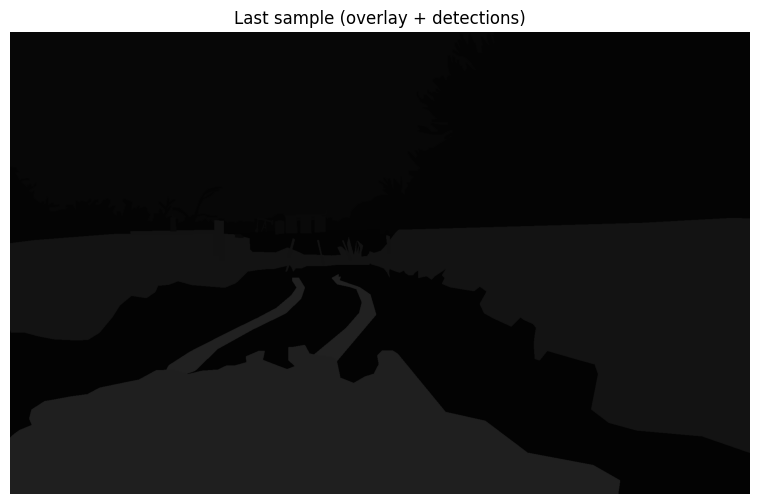

In [13]:
import numpy as np, cv2 as cv, matplotlib.pyplot as plt

USE_LIDAR = True  # set False to force RGB-only regardless

rows = []
last_vis = None
sampled = pairs.sample(min(5, len(pairs)), random_state=0)

for _, r in sampled.iterrows():
    try:
        img = cv.imread(r.rgb_path, cv.IMREAD_COLOR)
        if img is None:
            rows.append({"rgb": r.rgb_path, "lidar": r.lidar_path, "n_dets": -1, "n_usable": -1, "note":"img_read_fail"})
            continue

        uv = cam = None
        if USE_LIDAR and r.lidar_path and Path(r.lidar_path).exists():
            pts = load_lidar(r.lidar_path)
            if isinstance(pts, np.ndarray) and pts.size > 0:
                uv, cam = project_lidar_to_image(pts, T, K, D, img.shape)

        dets = detect_rocks(img, yolo)
        use  = usable_rock(dets, uv, cam, img.shape)

        vis = overlay_uv(img, uv) if uv is not None else img.copy()
        for d in dets:
            x1,y1,x2,y2 = d["bbox"]
            cv.rectangle(vis, (x1,y1), (x2,y2), (0,0,255), 2)
            lbl = f"rock {d.get('score',0):.2f}"
            cv.putText(vis, lbl, (x1, max(0,y1-4)), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255), 1)

        rows.append({"rgb": r.rgb_path, "lidar": r.lidar_path, "n_dets": len(dets), "n_usable": len(use)})
        last_vis = vis

    except Exception as e:
        rows.append({"rgb": r.rgb_path, "lidar": r.lidar_path, "n_dets": -1, "n_usable": -1, "note": f"err:{type(e).__name__}"})

summary = pd.DataFrame(rows)
display(summary)

if last_vis is not None:
    plt.figure(figsize=(10,6))
    plt.imshow(cv.cvtColor(last_vis, cv.COLOR_BGR2RGB))
    plt.title("Last sample (overlay + detections)")
    plt.axis("off")
    plt.show()
else:
    print("No valid frames to visualize.")


,rgb,lidar,n_dets,n_usable
0,C:\Users\Miles\data\RELLIS_LOCAL\rgb\frame0000...,C:\Users\Miles\data\RELLIS_LOCAL\lidar\000006.bin,0,0
1,C:\Users\Miles\data\RELLIS_LOCAL\rgb\frame0000...,C:\Users\Miles\data\RELLIS_LOCAL\lidar\000002.bin,0,0
2,C:\Users\Miles\data\RELLIS_LOCAL\rgb\frame0000...,C:\Users\Miles\data\RELLIS_LOCAL\lidar\000001.bin,0,0
3,C:\Users\Miles\data\RELLIS_LOCAL\rgb\frame0000...,C:\Users\Miles\data\RELLIS_LOCAL\lidar\000007.bin,0,0
4,C:\Users\Miles\data\RELLIS_LOCAL\rgb\frame0000...,C:\Users\Miles\data\RELLIS_LOCAL\lidar\000003.bin,0,0


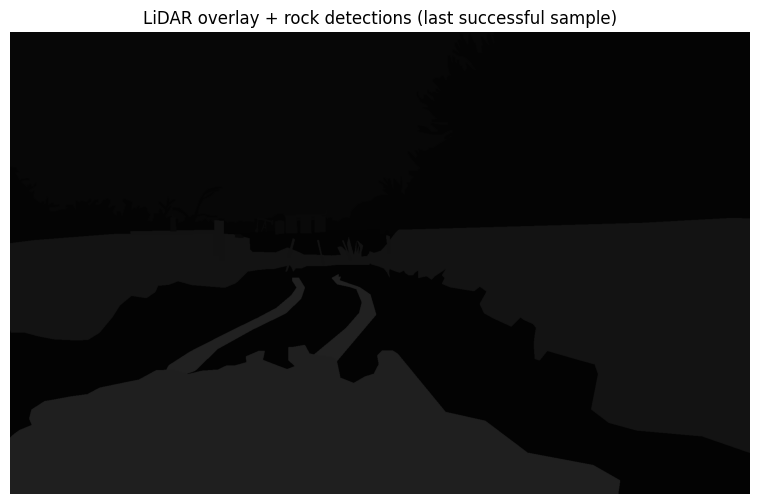

In [14]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2 as cv

# Guard: any pairs at all?
if len(pairs) == 0:
    raise ValueError("No paired RGB/LiDAR files found. Check DATA_ROOT/rgb and DATA_ROOT/lidar.")

sampled = pairs.sample(min(5, len(pairs)), random_state=0)
rows = []
last_vis = None

for _, r in sampled.iterrows():
    try:
        img = cv.imread(r.rgb_path, cv.IMREAD_COLOR)
        if img is None:
            rows.append(dict(rgb=r.rgb_path, lidar=r.lidar_path, n_dets=-1, n_usable=-1, note="img_read_fail"))
            continue

        pts = load_lidar(r.lidar_path)
        if pts is None or (isinstance(pts, np.ndarray) and pts.size == 0):
            rows.append(dict(rgb=r.rgb_path, lidar=r.lidar_path, n_dets=-1, n_usable=-1, note="lidar_empty"))
            continue

        uv, cam = project_lidar_to_image(pts, T, K, D, img.shape)
        dets = detect_rocks(img, yolo)
        use  = usable_rock(dets, uv, cam, img.shape)

        vis = overlay_uv(img, uv)
        for d in dets:
            x1,y1,x2,y2 = d["bbox"]
            cv.rectangle(vis, (x1,y1), (x2,y2), (0,0,255), 2)
            cv.putText(vis, f"rock {d.get('score',0):.2f}", (x1, max(0,y1-4)),
                       cv.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255), 1)

        rows.append(dict(rgb=r.rgb_path, lidar=r.lidar_path, n_dets=len(dets), n_usable=len(use)))
        last_vis = vis  # keep something to show

    except Exception as e:
        rows.append(dict(rgb=r.rgb_path, lidar=r.lidar_path, n_dets=-1, n_usable=-1, note=f"err:{type(e).__name__}"))

summary = pd.DataFrame(rows)
display(summary)

# Only plot if we actually produced a visualization
if last_vis is not None:
    plt.figure(figsize=(10,6))
    plt.imshow(cv.cvtColor(last_vis, cv.COLOR_BGR2RGB))
    plt.title("LiDAR overlay + rock detections (last successful sample)")
    plt.axis("off")
    plt.show()
else:
    print("No valid frames were visualized (all samples failed to load or process).")


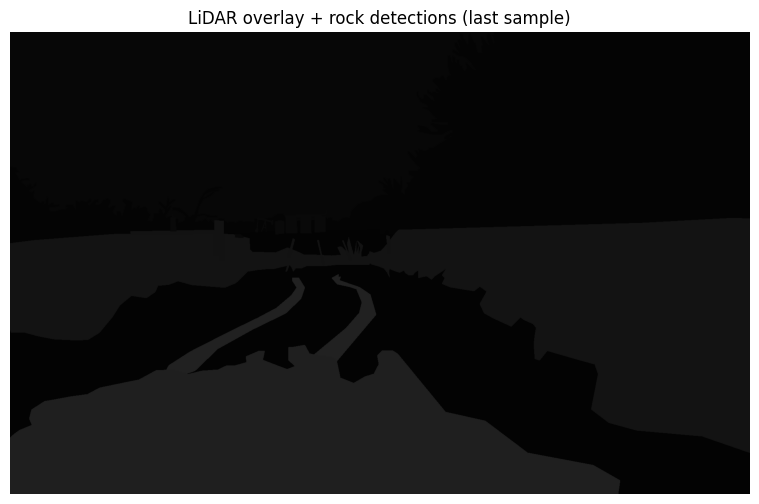

,rgb,lidar,n_dets,n_usable
0,C:\Users\Miles\data\RELLIS_LOCAL\rgb\frame0000...,C:\Users\Miles\data\RELLIS_LOCAL\lidar\000006.bin,0,0
1,C:\Users\Miles\data\RELLIS_LOCAL\rgb\frame0000...,C:\Users\Miles\data\RELLIS_LOCAL\lidar\000002.bin,0,0
2,C:\Users\Miles\data\RELLIS_LOCAL\rgb\frame0000...,C:\Users\Miles\data\RELLIS_LOCAL\lidar\000001.bin,0,0
3,C:\Users\Miles\data\RELLIS_LOCAL\rgb\frame0000...,C:\Users\Miles\data\RELLIS_LOCAL\lidar\000007.bin,0,0
4,C:\Users\Miles\data\RELLIS_LOCAL\rgb\frame0000...,C:\Users\Miles\data\RELLIS_LOCAL\lidar\000003.bin,0,0


In [15]:
import matplotlib.pyplot as plt

sampled = pairs.sample(min(5,len(pairs)), random_state=0)
rows=[]
for _, r in sampled.iterrows():
    img = cv.imread(r.rgb_path, cv.IMREAD_COLOR)
    pts = load_lidar(r.lidar_path)
    uv, cam = project_lidar_to_image(pts, T, K, D, img.shape)
    dets = detect_rocks(img, yolo)
    use = usable_rock(dets, uv, cam, img.shape)

    vis = overlay_uv(img, uv)
    for d in dets:
        x1,y1,x2,y2 = d["bbox"]
        cv.rectangle(vis, (x1,y1), (x2,y2), (0,0,255), 2)
        cv.putText(vis, f"rock {d['score']:.2f}", (x1,max(0,y1-4)), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255), 1)

    rows.append(dict(rgb=r.rgb_path, lidar=r.lidar_path, n_dets=len(dets), n_usable=len(use)))

plt.figure(figsize=(10,6))
plt.imshow(cv.cvtColor(vis, cv.COLOR_BGR2RGB))
plt.title("LiDAR overlay + rock detections (last sample)")
plt.axis("off")
plt.show()

import pandas as pd
summary = pd.DataFrame(rows)
summary
